In [2]:
# Cell 1: Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from typing import Dict, Tuple

print("Imports successful")
# Cell 2: Load Data
# Load generation profiles
print("Loading generation profiles...")
gen_profiles = pd.read_csv('ninja_pv_wind_profiles_singleindex_be_simplified.csv',
                         delimiter=';',
                         parse_dates=['time'],
                         index_col='time')

# Display first few rows and basic info
print("\nGeneration profiles head:")
print(gen_profiles.head())
print("\nGeneration profiles info:")
print(gen_profiles.info())

# Cell 3: Load Demand Data
print("Loading demand data...")
demand_data = pd.read_csv('time_series_60min_singleindex_BE_simplified.csv', 
                        delimiter=';', 
                        parse_dates=['utc_timestamp'],
                        index_col='utc_timestamp')

# Clean demand data
demand_data['BE_load_actual_entsoe_transparency'] = (
    demand_data['BE_load_actual_entsoe_transparency']
    .replace('', np.nan)  # Replace empty strings with NaN
    .str.replace('.', '', regex=False)  # Remove thousand separators
    .str.replace(',', '.', regex=False)  # Fix decimal points
    .astype(float)  # Convert to float
    / 10000  # Scale down by 1000 to get GW
)

print("\nDemand data head:")
print(demand_data.head())
print("\nDemand data info:")
print(demand_data.info())
# Cell 4: Data Preprocessing
# Filter pre-2020 data
gen_profiles = gen_profiles[gen_profiles.index.year < 2020]
demand_data = demand_data[demand_data.index.year < 2020]

# Remove any remaining NaN values
gen_profiles = gen_profiles.dropna()
demand_data = demand_data.dropna()

print("Data shapes after preprocessing:")
print(f"Generation profiles shape: {gen_profiles.shape}")
print(f"Demand data shape: {demand_data.shape}")

# Verify data alignment
print("\nChecking data alignment...")
print(f"Generation profiles index range: {gen_profiles.index.min()} to {gen_profiles.index.max()}")
print(f"Demand data index range: {demand_data.index.min()} to {demand_data.index.max()}")

print(demand_data)
print(gen_profiles)

Imports successful
Loading generation profiles...

Generation profiles head:
                           BE_pv_national_current  BE_wind_offshore_current  \
time                                                                          
2015-01-01 00:00:00+00:00                     0.0                    0.5116   
2015-01-01 01:00:00+00:00                     0.0                    0.5036   
2015-01-01 02:00:00+00:00                     0.0                    0.5238   
2015-01-01 03:00:00+00:00                     0.0                    0.5404   
2015-01-01 04:00:00+00:00                     0.0                    0.5181   

                           BE_wind_onshore_current  
time                                                
2015-01-01 00:00:00+00:00                   0.1346  
2015-01-01 01:00:00+00:00                   0.1372  
2015-01-01 02:00:00+00:00                   0.1514  
2015-01-01 03:00:00+00:00                   0.1673  
2015-01-01 04:00:00+00:00                   0.1865 

In [3]:
# Cell 5: Simulation Function

def simulate_hourly(demand, gen_profiles, params):
    """
    Simulates hourly energy flows with storage and curtailment.
    
    Args:
        demand (pd.Series): Hourly demand in MW.
        gen_profiles (pd.DataFrame): Hourly capacity factors for solar, onshore, and offshore wind.
        params (dict): System parameters including capacities and storage specs.
    
    Returns:
        pd.DataFrame: Hourly simulation results with generation, storage, and curtailment.
    """
    # Extract parameters
    Ps = params['Ps']  # Solar capacity (MW)
    Pw = params['Pw']  # Onshore wind capacity (MW)
    Po = params['Po']  # Offshore wind capacity (MW)
    Eb = params['Eb']  # Storage energy capacity (MWh)
    Pb = params['Pb']  # Storage power capacity (MW)
    soc_initial = params.get('soc_initial', Eb * 0.5)  # Initial SOC
    
    # Preallocate results
    hours = len(demand)
    results = pd.DataFrame(index=gen_profiles.index, columns=[
        'solar_gen', 'wind_gen', 'total_gen', 'demand', 'excess',
        'charge', 'discharge', 'soc', 'curtail'
    ])
    
    # Initialize SOC
    soc_prev = soc_initial
    results.iloc[0, results.columns.get_loc('soc')] = soc_prev
    
    for i in range(hours):
        # Current hour data
        solar_cf = gen_profiles.iloc[i, 0]
        wind_offshore_cf = gen_profiles.iloc[i, 1]
        wind_onshore_cf = gen_profiles.iloc[i, 2]
        current_demand = demand.iloc[i]
        
        # Calculate generation
        solar_gen = Ps * solar_cf
        wind_gen = Pw * wind_onshore_cf + Po * wind_offshore_cf
        total_gen = solar_gen + wind_gen
        excess = total_gen - current_demand
        
        # Storage operations
        if excess > 0:
            # Charge phase
            charge = min(excess, Pb, Eb - soc_prev)
            soc_new = soc_prev + charge
            # Check if SOC reached capacity to determine curtailment
            if soc_new >= Eb:
                soc_new = Eb  # Clamp to max capacity
                curtail = max(0, excess - charge)
            else:
                curtail = 0
            discharge = 0
        else:
            # Discharge phase
            discharge = min(-excess, Pb, soc_prev)
            soc_new = soc_prev - discharge
            charge = 0
            curtail = 0
        
        # Clamp SOC between 0 and Eb
        soc_new = max(0, min(soc_new, Eb))
        
        # Save results
        results.iloc[i] = [
            solar_gen, wind_gen, total_gen, current_demand, excess,
            charge, discharge, soc_new, curtail
        ]
        
        # Update SOC for next hour
        soc_prev = soc_new
    
    return results

# Cell 6: Run Simulation with Baseline Parameters

# Define system parameters (modify as needed)
baseline_params = {
    'Ps': 103177,   # Solar capacity (MW)
    'Pw': 106584,   # Onshore wind (MW)
    'Po': 10318,    # Offshore wind (MW)
    'Eb': 39800,   # Storage energy capacity (MWh)
    'Pb': 29500,    # Storage power capacity (MW)
    'soc_initial': 20000  # MW can modify this value)
}

# Align demand and generation data (assuming indices match)
demand_series = demand_data['BE_load_actual_entsoe_transparency']

# Run simulation
sim_results = simulate_hourly(demand_series, gen_profiles, baseline_params)

# Cell 7: Energy Conservation Check

# Verify energy balance for all hours
sim_results['energy_balance'] = (
    sim_results['total_gen'] 
    + sim_results['discharge'] 
    - sim_results['charge'] 
    - sim_results['curtail'] 
    - sim_results['demand']
)

# Check if any hour violates energy conservation
conservation_violations = sim_results[abs(sim_results['energy_balance']) > 1e-3]
if conservation_violations.empty:
    print("Energy conservation verified for all hours.")
else:
    print(f"Energy conservation violated in {len(conservation_violations)} hours.")

# Cell 8: Storage Continuity and SOC Bounds Check

# Check SOC bounds (0 <= SOC <= Eb)
soc_bounds_violations = sim_results[(sim_results['soc'] < 0) | (sim_results['soc'] > baseline_params['Eb'])]
if soc_bounds_violations.empty:
    print("All SOC values within bounds.")
else:
    print(f"SOC out of bounds in {len(soc_bounds_violations)} hours.")

# Check SOC continuity (SOC(t) = SOC(t-1) + charge - discharge)
# Shift SOC to compare with next hour's previous SOC
sim_results['soc_prev'] = sim_results['soc'].shift(1)
sim_results.loc[sim_results.index[0], 'soc_prev'] = baseline_params['soc_initial']

soc_continuity_check = (
    sim_results['soc'] 
    - (sim_results['soc_prev'] + sim_results['charge'] - sim_results['discharge'])
)
continuity_violations = sim_results[abs(soc_continuity_check) > 1e-3]
if continuity_violations.empty:
    print("SOC continuity maintained.")
else:
    print(f"SOC continuity violated in {len(continuity_violations)} hours.")

# Cell 9: Curtailment Logic Check

# Curtailment should only occur when SOC == Eb
curtailment_violations = sim_results[
    (sim_results['curtail'] > 0) 
    & (sim_results['soc'] != baseline_params['Eb'])
]
if curtailment_violations.empty:
    print("Curtailment only occurs when storage is full.")
else:
    print(f"Invalid curtailment in {len(curtailment_violations)} hours.")

Energy conservation violated in 870 hours.
All SOC values within bounds.
SOC continuity maintained.
Curtailment only occurs when storage is full.


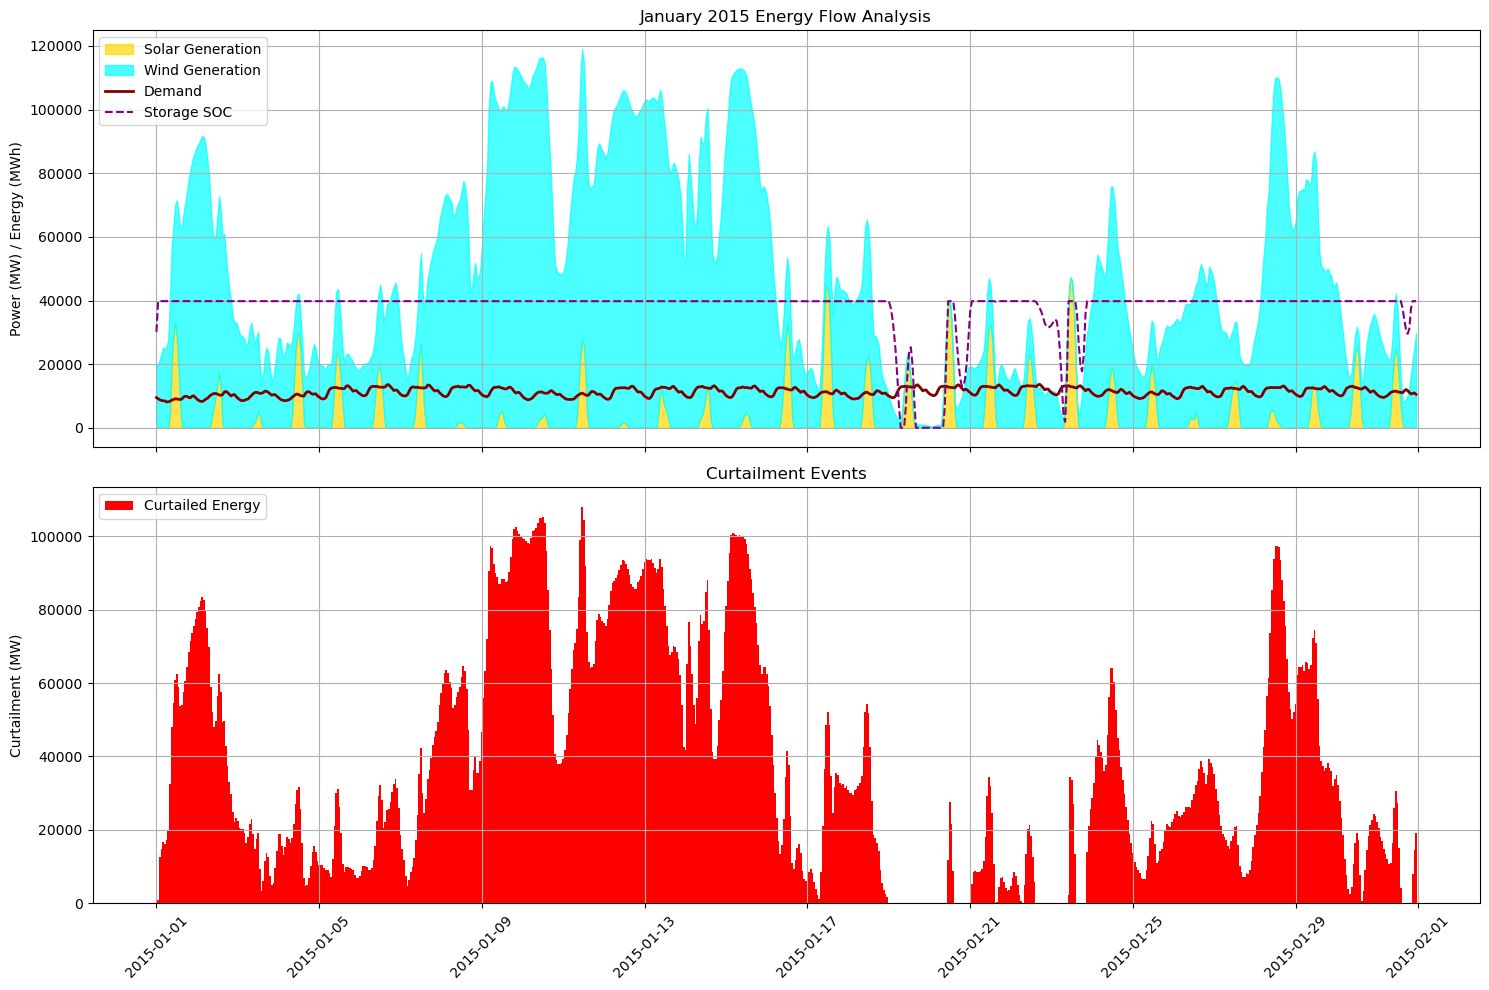

In [4]:
# Cell 11 (Revised): Visualization Function with Data Cleaning
def plot_january_energy(sim_results):
    # Filter and clean January 2015 data
    jan_data = sim_results.loc['2015-01'].copy()
    
    # Convert to numeric types
    numeric_cols = ['solar_gen', 'wind_gen', 'demand', 'soc', 'curtail']
    jan_data[numeric_cols] = jan_data[numeric_cols].apply(pd.to_numeric, errors='coerce')
    
    # Ensure proper datetime index
    jan_data.index = pd.to_datetime(jan_data.index)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    
    # Energy Flow Plot
    ax1.fill_between(jan_data.index, 0, jan_data['solar_gen'], 
                    label='Solar Generation', alpha=0.7, color='gold')
    ax1.fill_between(jan_data.index, jan_data['solar_gen'], 
                    jan_data['solar_gen'] + jan_data['wind_gen'],
                    label='Wind Generation', alpha=0.7, color='cyan')
    ax1.plot(jan_data.index, jan_data['demand'], 
            label='Demand', color='maroon', linewidth=2)
    ax1.plot(jan_data.index, jan_data['soc'], 
            label='Storage SOC', color='purple', linestyle='--')
    
    ax1.set_title('January 2015 Energy Flow Analysis')
    ax1.set_ylabel('Power (MW) / Energy (MWh)')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    # Curtailment Plot
    ax2.bar(jan_data.index, jan_data['curtail'], 
           width=1/24, label='Curtailed Energy', color='red')
    ax2.set_title('Curtailment Events')
    ax2.set_ylabel('Curtailment (MW)')
    ax2.legend(loc='upper left')
    ax2.grid(True)
    
    # Format x-axis dates
    plt.xticks(rotation=45)
    fig.tight_layout()
    plt.show()

# Cell 12: Generate January Visualization
plot_january_energy(sim_results)

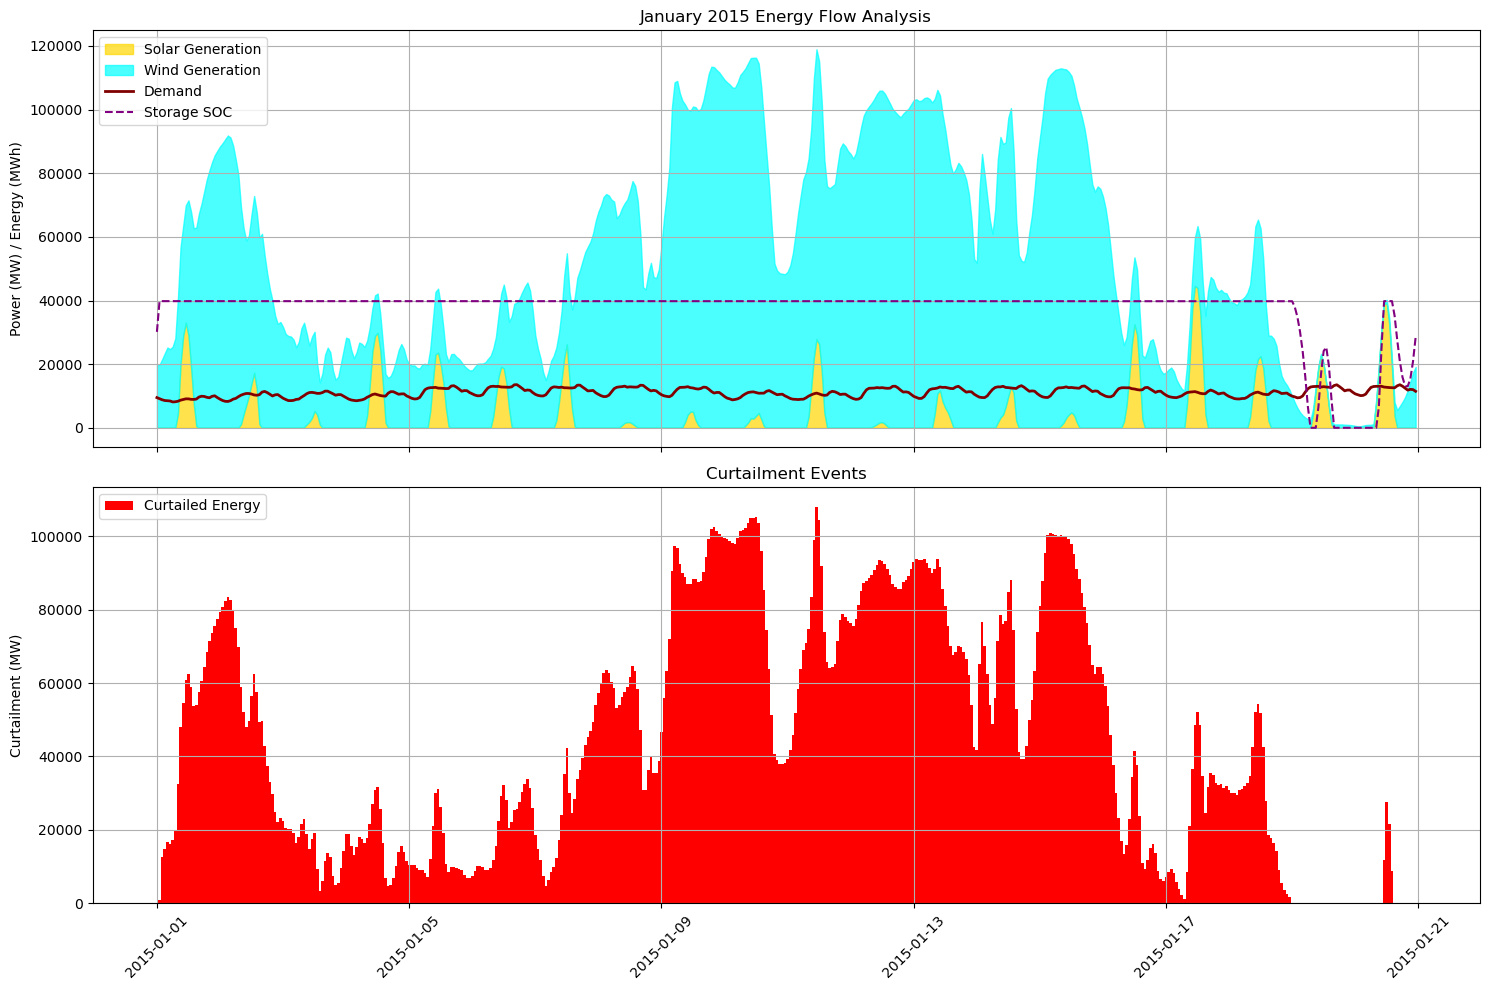

In [5]:
# For specific week analysis
week_data = sim_results.loc['2015-01-01':'2015-01-20']
plot_january_energy(week_data)  # Would need to rename/adapt function

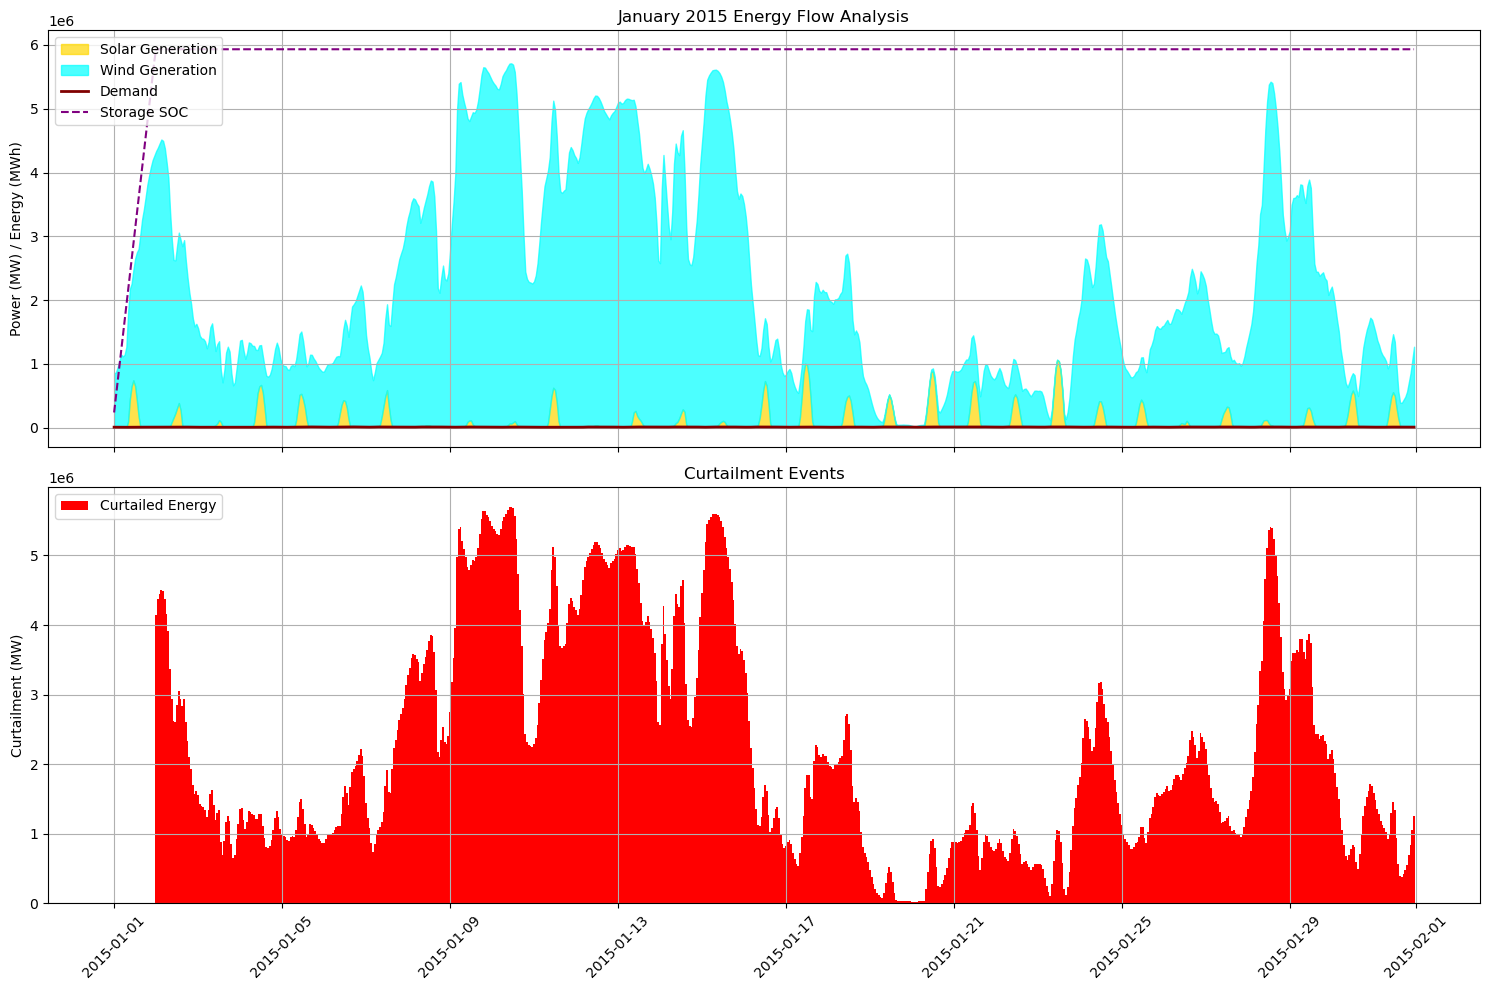

In [12]:
test_params = {
    'Ps': 2323495, 
    'Pw': 5641662, 
    'Po': 183400,
    'Eb': 5932635,  # Small storage
    'Pb': 239493,
    'soc_initial': 500
}

# Should show unmet demand when storage depletes
test_results = simulate_hourly(demand_series, gen_profiles, test_params)
plot_january_energy(test_results)

In [11]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def calculate_total_cost(params, costs):
    """Calculate total system cost based on capacities and unit costs."""
    return (
        params['Eb'] * costs['storage_kwh'] +
        params['Pb'] * costs['storage_kw'] +
        params['Ps'] * costs['pv'] +
        params['Pw'] * costs['wind_onshore'] +
        params['Po'] * costs['wind_offshore']
    )

def monte_carlo_optimization(demand, gen_profiles, n_iterations, costs, bounds):
    """
    Perform Monte Carlo simulation to find lowest cost configuration.
    
    Args:
        demand (pd.Series): Hourly demand data
        gen_profiles (pd.DataFrame): Generation profiles
        n_iterations (int): Number of Monte Carlo iterations
        costs (dict): Unit costs for different components
        bounds (dict): Min/max bounds for each parameter
    
    Returns:
        tuple: Best parameters and corresponding results
    """
    best_cost = float('inf')
    best_params = None
    best_results = None
    
    # Pre-allocate parameter arrays for vectorized operations
    param_names = ['Ps', 'Pw', 'Po', 'Eb', 'Pb']
    
    # Track progress with tqdm
    for i in tqdm(range(n_iterations)):
        # Sample random parameters within bounds
        params = {
            'Ps': np.random.uniform(bounds['Ps_min'], bounds['Ps_max']),
            'Pw': np.random.uniform(bounds['Pw_min'], bounds['Pw_max']),
            'Po': np.random.uniform(bounds['Po_min'], bounds['Po_max']),
            'Eb': np.random.uniform(bounds['Eb_min'], bounds['Eb_max']),
            'Pb': np.random.uniform(bounds['Pb_min'], bounds['Pb_max']),
            'soc_initial': 0  # Start empty
        }
        
        # Calculate total system cost before running simulation (early filtering)
        total_cost = calculate_total_cost(params, costs)
        
        # Skip simulation if cost already exceeds best cost
        if total_cost >= best_cost:
            continue
        
        # Run simulation
        results = simulate_hourly(demand, gen_profiles, params)
        
        # Calculate reliability metrics more efficiently
        unmet_demand = (results['demand'] - 
                       (results['total_gen'] + results['discharge'] - 
                        results['charge'] - results['curtail']))
        reliability = (unmet_demand <= 0).mean()
        
        # Update best solution if reliability threshold met and cost is lower
        if reliability >= 0.95 and total_cost < best_cost:
            best_cost = total_cost
            best_params = params.copy()
            best_results = results.copy()
    
    return best_params, best_results
    # Define costs
costs = {
    'storage_kwh': 366,  # $ per kWh
    'storage_kw': 8500,  # $ per kW
    'pv': 965,  # $ per kW
    'wind_onshore': 1583,  # $ per kW
    'wind_offshore': 3138  # $ per kW
}

# Define parameter bounds
bounds = {
    'Ps_min': 50000,  # Minimum solar capacity
    'Ps_max': 15000000,  # Maximum solar capacity
    'Pw_min': 5000000,  # Minimum onshore wind capacity
    'Pw_max': 15000000,  # Maximum onshore wind capacity
    'Po_min': 50000,   # Minimum offshore wind capacity
    'Po_max': 20000000,  # Maximum offshore wind capacity
    'Eb_min': 200000,  # Minimum storage energy capacity
    'Eb_max': 60000000,  # Maximum storage energy capacity
    'Pb_min': 150000,  # Minimum storage power capacity
    'Pb_max': 450000   # Maximum storage power capacity
}

# Run optimization
n_iterations = 10000
best_params, best_results = monte_carlo_optimization(
    demand_series, 
    gen_profiles, 
    n_iterations, 
    costs, 
    bounds
)

# Print results
print("\nBest configuration found:")
print(f"Total cost: ${calculate_total_cost(best_params, costs):,.2f}")
for param, value in best_params.items():
    print(f"{param}: {value:,.0f}")

100%|██████████| 10000/10000 [01:20<00:00, 123.63it/s]


Best configuration found:
Total cost: $15,955,471,770.15
Ps: 2,323,495
Pw: 5,641,662
Po: 183,400
Eb: 5,932,635
Pb: 239,493
soc_initial: 0


100%|██████████| 100/100 [10:25<00:00,  6.26s/it]
C:\Users\karld\AppData\Local\Temp\ipykernel_11648\2025421063.py:70: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_pivot = heatmap_data.pivot_table(
C:\Users\karld\AppData\Local\Temp\ipykernel_11648\2025421063.py:70: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_pivot = heatmap_data.pivot_table(
C:\Users\karld\AppData\Local\Temp\ipykernel_11648\2025421063.py:70: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_pivot = heatmap_data.piv

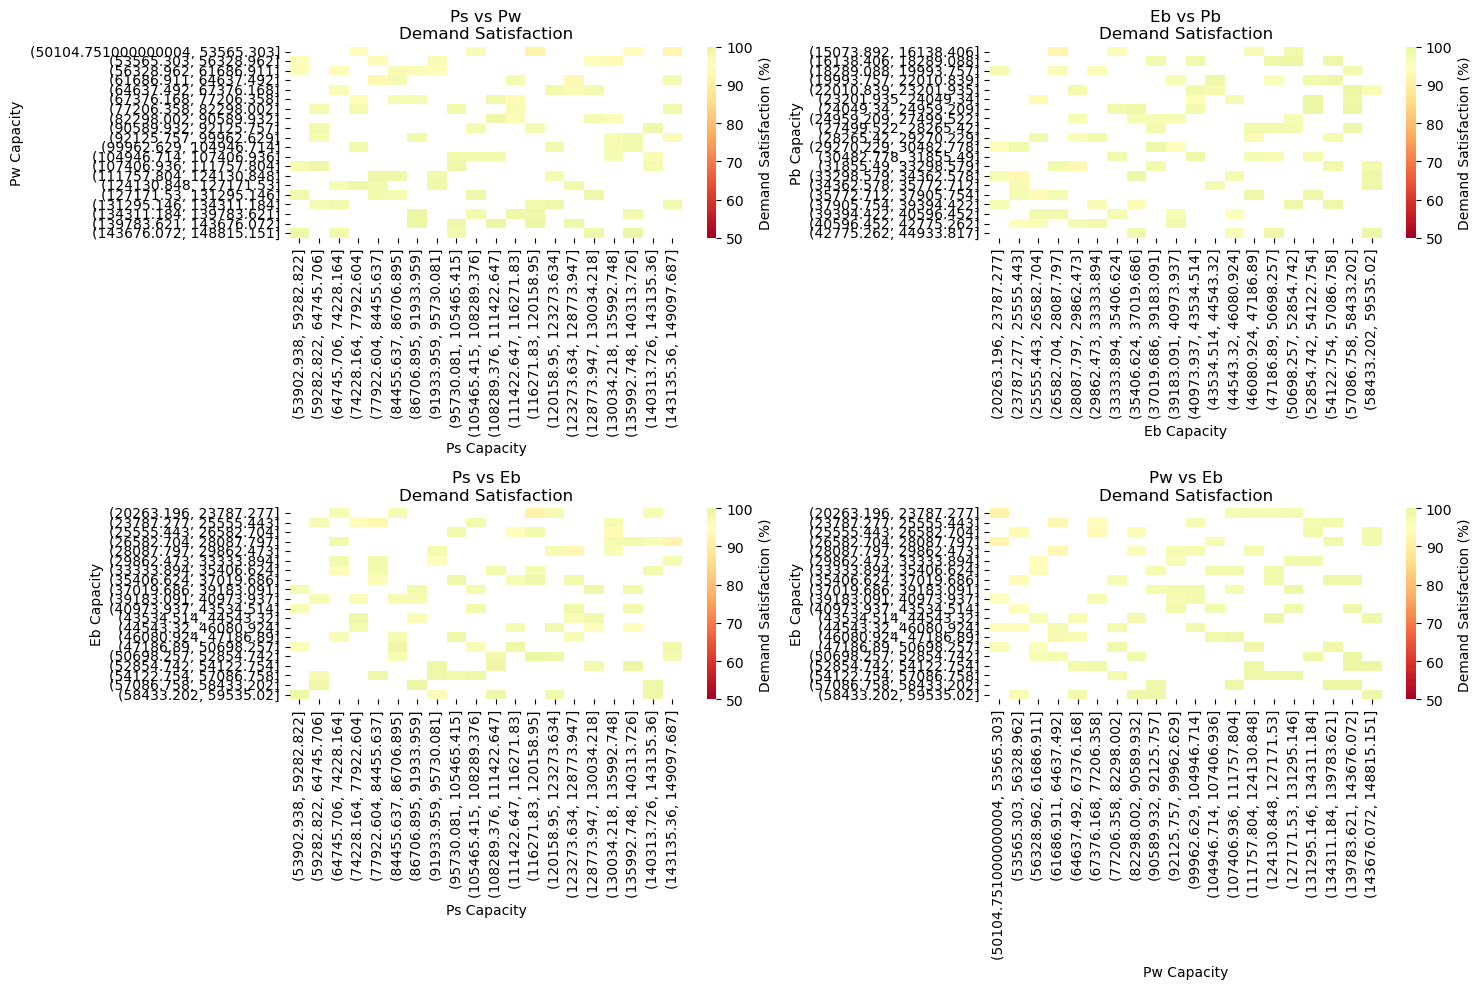


Top 5 configurations by demand satisfaction:
        Ps      Pw     Po     Eb     Pb  total_cost  demand_satisfaction
95 136,733 146,716 17,631 53,895 24,291 645,724,803                   99
32 108,828 142,811 16,996 53,044 23,574 604,218,890                   99
51  91,371 142,730 11,353 57,492 23,114 567,252,583                   99
8  118,218 142,777 15,032 52,108 16,154 543,648,494                   99
77  90,840 136,351 12,935 57,330 24,486 573,211,922                   99


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def run_monte_carlo_with_tracking(demand, gen_profiles, n_iterations, costs, bounds):
    """
    Run Monte Carlo simulation and track all results for visualization
    """
    # Initialize tracking arrays
    tracked_results = pd.DataFrame(columns=[
        'Ps', 'Pw', 'Po', 'Eb', 'Pb', 'total_cost', 'demand_satisfaction'
    ])
    
    for _ in tqdm(range(n_iterations)):
        # Sample random parameters
        params = {
            'Ps': np.random.uniform(bounds['Ps_min'], bounds['Ps_max']),
            'Pw': np.random.uniform(bounds['Pw_min'], bounds['Pw_max']),
            'Po': np.random.uniform(bounds['Po_min'], bounds['Po_max']),
            'Eb': np.random.uniform(bounds['Eb_min'], bounds['Eb_max']),
            'Pb': np.random.uniform(bounds['Pb_min'], bounds['Pb_max']),
            'soc_initial': 0
        }
        
        # Run simulation
        results = simulate_hourly(demand, gen_profiles, params)
        
        # Calculate demand satisfaction
        demand_met = (results['total_gen'] + results['discharge'] - 
                     results['charge'] - results['curtail'] >= results['demand'])
        demand_satisfaction = demand_met.mean() * 100
        
        # Calculate total cost
        total_cost = calculate_total_cost(params, costs)
        
        # Store results
        tracked_results.loc[len(tracked_results)] = [
            params['Ps'], params['Pw'], params['Po'], 
            params['Eb'], params['Pb'], total_cost, demand_satisfaction
        ]
    
    return tracked_results

def create_heatmaps(tracked_results):
    """
    Create heatmaps showing relationships between parameters and demand satisfaction
    """
    plt.figure(figsize=(15, 10))
    
    # Create parameter pairs for heatmaps
    param_pairs = [
        ('Ps', 'Pw'),  # Solar vs Onshore Wind
        ('Eb', 'Pb'),  # Storage Energy vs Power
        ('Ps', 'Eb'),  # Solar vs Storage Energy
        ('Pw', 'Eb')   # Wind vs Storage Energy
    ]
    
    for idx, (param1, param2) in enumerate(param_pairs, 1):
        plt.subplot(2, 2, idx)
        
        # Create 2D histogram
        heatmap_data = pd.DataFrame({
            'x': tracked_results[param1],
            'y': tracked_results[param2],
            'satisfaction': tracked_results['demand_satisfaction']
        })
        
        # Pivot data for heatmap
        heatmap_pivot = heatmap_data.pivot_table(
            values='satisfaction',
            index=pd.qcut(heatmap_data['y'], 20),
            columns=pd.qcut(heatmap_data['x'], 20),
            aggfunc='mean'
        )
        
        # Create heatmap
        sns.heatmap(heatmap_pivot, 
                    cmap='RdYlGn',
                    center=95,
                    vmin=50,
                    vmax=100,
                    cbar_kws={'label': 'Demand Satisfaction (%)'}
        )
        
        plt.title(f'{param1} vs {param2}\nDemand Satisfaction')
        plt.xlabel(f'{param1} Capacity')
        plt.ylabel(f'{param2} Capacity')
    
    plt.tight_layout()
    plt.show()

# Run Monte Carlo simulation with tracking
n_iterations = 100
tracked_results = run_monte_carlo_with_tracking(
    demand_series,
    gen_profiles,
    n_iterations,
    costs,
    bounds
)

# Create visualization
create_heatmaps(tracked_results)

# Print summary of best configurations
print("\nTop 5 configurations by demand satisfaction:")
print(tracked_results.sort_values('demand_satisfaction', ascending=False)
      .head()
      .to_string(float_format=lambda x: f"{x:,.0f}"))